In [40]:
import pandas  as pd
import os
import sys
sys.path.append('./src')
import data_io, params, SIF_embedding
import numpy as np
import 

In [23]:
cropus_path = os.path.abspath('../data/news_chinese_sqlResult_1558435.csv')
glove_word2vector_path=os.path.abspath("../data/chinese_data_cropus_vectors.txt")
news_cropus_path = os.path.abspath("../data/news_data.txt")
word_freauency_path = os.path.abspath("../data/chinese_data_cropus_vocab.txt")
weight_params = 1e-3 # the parameter in the SIF weighting scheme, usually in the range [3e-5, 3e-3]
rmpc = 1 # number of principal components to remove in SIF weighting scheme

In [24]:
# 加载glove词向量
#Word2Indx['word'] = word_indx
#Word2vector[Word2Indx['word'] ] is the word_indx'th word_vector
(Word2Indx, Word2vector) = data_io.getWordmap(glove_word2vector_path)
# word2weight['word'] is the weight for the word 'word'
Word2Weight = data_io.getWordWeight(word_freauency_path, weight_params) 

Index2Weight= data_io.getWeight(Word2Indx, Word2Weight) # Index2Weight[i] is the weight for the i-th word

['430394']
['24523']
['299']
['67']
['36']
['23']
['17']
['10']
['6']


In [25]:
sentences = []
#将新闻文章变成list
with open(news_cropus_path) as f:
    for line in f:
        sentences.append(line)

In [26]:
print(len(sentences))

89607


In [32]:
# load sentences
#x[i] is sentences[i]'s index of sequence
#m is mask ,use 1 and 0  represent different sentence.
word_idx_seq_of_sentence, mask = data_io.sentences2idx(sentences, Word2Indx) # x is the array of word indices, m is the binary mask indicating whether there is a word in that location
#sentence_word_weight
word_weight_of_sentence = data_io.seq2weight(word_idx_seq_of_sentence, mask, Index2Weight) # get word weights
# set parameters

AttributeError: 'params' object has no attribute 'params'

In [35]:
params = params.params()
params.rmpc = rmpc

In [36]:
# get SIF embedding
# embedding[i,:] is the embedding for sentence i
embedding = SIF_embedding.SIF_embedding(Word2vector, word_idx_seq_of_sentence, word_weight_of_sentence, params) 

In [42]:
np.save("sentence2vector.npy",embedding)

In [37]:
embedding.shape

(89607, 50)

In [58]:
news_sentence_embed_vector = embedding
news_sentence_embed_vector[0]

array([ 0.00089048,  0.02454774, -0.03781125, -0.02711399, -0.1710236 ,
        0.12716949,  0.20108985, -0.03190947,  0.02004501, -0.05232528,
        0.07656174, -0.07048745, -0.19263127, -0.08026742, -0.30537211,
        0.08218371, -0.05765594,  0.18046428,  0.04680579,  0.20554955,
        0.30881865,  0.05272279, -0.06371776,  0.00058033,  0.13698873,
       -0.04779066,  0.17742225,  0.15315233,  0.01870738,  0.1280525 ,
       -0.15690721, -0.05865687,  0.12369457, -0.17584271,  0.28075816,
        0.00692654,  0.0898805 ,  0.18085011,  0.28719106,  0.11593817,
        0.07575179,  0.17381612, -0.02507069, -0.13272166, -0.0521053 ,
       -0.03812526, -0.27981632, -0.11053169, -0.03878611,  0.08074484])

In [43]:
#embedding is all news vector
#it is the input X
#Y is 新华社or not  1/0

In [46]:
df = pd.read_csv(cropus_path,error_bad_lines=False,header=None,dtype='str')


b'Skipping line 64072: expected 7 fields, saw 32\nSkipping line 84179: expected 7 fields, saw 31\n'


In [51]:
print(df.loc[df.iloc[:,2].apply(lambda x:x == '新华社'),:])

           0                 1    2  \
3      89614               NaN  新华社   
39     89578               NaN  新华社   
95     89522               NaN  新华社   
113    89504               NaN  新华社   
305    89312               NaN  新华社   
312    89305               NaN  新华社   
314    89303               NaN  新华社   
543    89074               刘瑞莹  新华社   
545    89072               NaN  新华社   
651    88966                王点  新华社   
671    88946                王点  新华社   
679    88938                王点  新华社   
715    88902                李芳  新华社   
794    88823               卜晓明  新华社   
810    88807               张启畅  新华社   
816    88801               张雪飞  新华社   
909    88708               NaN  新华社   
931    88686               NaN  新华社   
934    88683                邓茜  新华社   
937    88680               NaN  新华社   
940    88677               NaN  新华社   
943    88674                王强  新华社   
946    88671               王乃水  新华社   
951    88666               NaN  新华社   
954    88663             

In [52]:
Y = []
for newspaper_office in df.iloc[:,2]:
    if newspaper_office == '新华社':
        Y.append(1)
    else:
        Y.append(0)        

#### Y is lable,Y[ith] = 1  means  news_sentence_embed_vector[ith] is written by 新华社
#### X is news_sentence_embed_vector

In [63]:
n_samples = len(Y)
postive_Y_samples = sum(Y)
negative_Y_samples = n_samples - postive_Y_samples
N = len(news_sentence_embed_vector)
dim = len(news_sentence_embed_vector[0])
print('''sentence'totals:{} ,sentence vector dim is {} , numbers of sample is {} , postive label numbers is {} , negative label numbers is {}'''\
     .format(N,dim,n_samples,postive_Y_samples,negative_Y_samples))
print('''postive samples percent is {}% '''.format(str(postive_Y_samples/n_samples*100)))

sentence'totals:89607 ,sentence vector dim is 50 , numbers of sample is 89607 , postive label numbers is 78657 , negative label numbers is 10950
postive samples percent is 87.77997254678765% 


In [64]:
X = news_sentence_embed_vector

In [73]:
from sklearn.model_selection import train_test_split

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.25,random_state=0)

In [80]:
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

In [87]:
lsr_clr = linear_model.LogisticRegression()
lsr_clr.fit(X_train,y_train)

/home/mk/anaconda3/envs/python3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [109]:
svc_clr = SVC(probability=True)
svc_clr.fit(X_train,y_train)

/home/mk/anaconda3/envs/python3.6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [272]:
SVC?

In [273]:
svc_clr_blance = SVC(probability=True,class_weight='balanced')
svc_clr_blance.fit(X_train,y_train)

/home/mk/anaconda3/envs/python3.6/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [89]:
dt_clr = tree.DecisionTreeClassifier()
dt_clr.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [90]:
rf_clr = RandomForestClassifier()
rf_clr.fit(X_train,y_train)

/home/mk/anaconda3/envs/python3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [91]:
bg_clr = BaggingClassifier()
bg_clr.fit(X_train,y_train)

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False)

In [92]:
ad_clr = AdaBoostClassifier()
ad_clr.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [93]:
from sklearn import metrics

In [155]:
clrs = [lsr_clr,svc_clr,svc_clr_blance,dt_clr,rf_clr,bg_clr,ad_clr]
y_scores = []
y_hat = []
for i,clr in enumerate(clrs):
    print(i)
    y_scores.append(clr.predict_proba(X_test))
    y_hat.append(clr.predict(X_test))

0
1
2
3
4
5


In [114]:
lsr_clr.predict(X_test)

array([1, 1, 1, ..., 1, 1, 1])

In [115]:
lsr_clr.decision_function(X_test)

array([ 8.30216565, 13.886741  ,  3.89895717, ...,  0.37321299,
        7.81917546,  9.35476269])

In [113]:
lsr_clr.predict_proba(X_test)

array([[2.47917730e-04, 9.99752082e-01],
       [9.31246399e-07, 9.99999069e-01],
       [1.98605954e-02, 9.80139405e-01],
       ...,
       [4.07764879e-01, 5.92235121e-01],
       [4.01791473e-04, 9.99598209e-01],
       [8.65447235e-05, 9.99913455e-01]])

In [112]:
for y_hat in y_hats:
    print(y_hat)

[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 0 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]


In [111]:
for y_score in y_scores:
    print(y_score)

[[2.47917730e-04 9.99752082e-01]
 [9.31246399e-07 9.99999069e-01]
 [1.98605954e-02 9.80139405e-01]
 ...
 [4.07764879e-01 5.92235121e-01]
 [4.01791473e-04 9.99598209e-01]
 [8.65447235e-05 9.99913455e-01]]
[[9.27401400e-08 9.99999907e-01]
 [3.68141871e-13 1.00000000e+00]
 [3.75503310e-03 9.96244967e-01]
 ...
 [4.38696711e-01 5.61303289e-01]
 [8.93594747e-07 9.99999106e-01]
 [2.42250793e-09 9.99999998e-01]]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[[0.  1. ]
 [0.  1. ]
 [0.1 0.9]
 ...
 [0.5 0.5]
 [0.  1. ]
 [0.  1. ]]
[[0.  1. ]
 [0.  1. ]
 [0.3 0.7]
 ...
 [0.4 0.6]
 [0.  1. ]
 [0.  1. ]]
[[0.4510666  0.5489334 ]
 [0.44398663 0.55601337]
 [0.47448699 0.52551301]
 ...
 [0.48987596 0.51012404]
 [0.47108707 0.52891293]
 [0.45451468 0.54548532]]


In [264]:
from sklearn.metrics import roc_curve, auc,confusion_matrix,f1_score
import matplotlib.pylab as plt

In [119]:
y_scores[0]

array([[2.47917730e-04, 9.99752082e-01],
       [9.31246399e-07, 9.99999069e-01],
       [1.98605954e-02, 9.80139405e-01],
       ...,
       [4.07764879e-01, 5.92235121e-01],
       [4.01791473e-04, 9.99598209e-01],
       [8.65447235e-05, 9.99913455e-01]])

In [126]:
fpr,tpr,_ = roc_curve(y_test,y_scores[0][:,0])    

In [127]:
roc_auc = auc(fpr, tpr)

In [128]:
roc_auc

0.013474671449842884

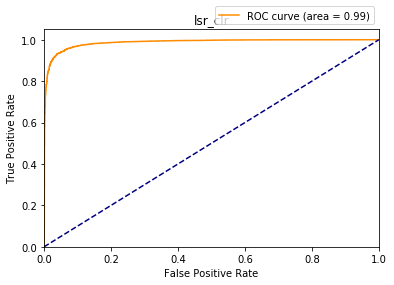

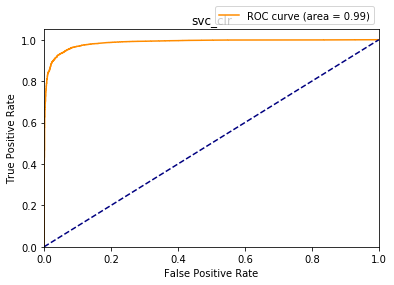

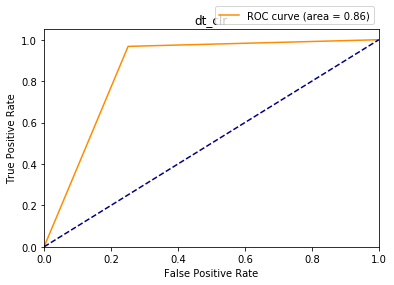

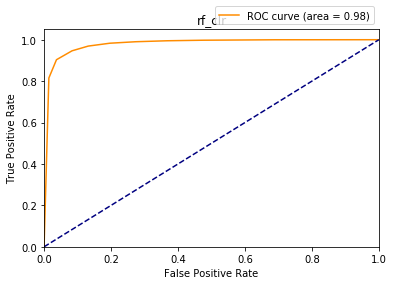

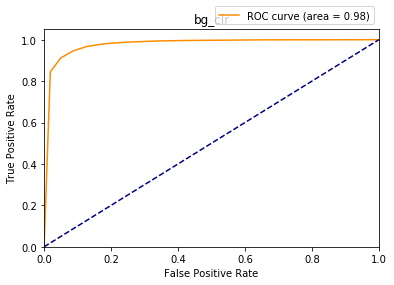

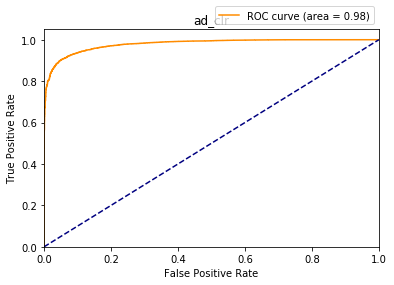

In [189]:
#Plot of a ROC curve for a specific class
clrs = ['lsr_clr','svc_clr','dt_clr','rf_clr','bg_clr','ad_clr']
for idx,y_score in enumerate(y_scores):
    fpr,tpr,_ = roc_curve(y_test,y_score[:,1]) 
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(clrs[idx])
    plt.legend(loc="lower right",bbox_to_anchor=[1,1])

In [265]:
f1_score()

In [260]:

def plot_confusion_matrix(confusion_mat,strs):
    plt.figure()
    plt.imshow(confusion_mat,interpolation='nearest',cmap=plt.cm.Paired)
    plt.title('Confusion Matrix '+strs)
    plt.colorbar()
    plt.xticks([1,0],[1,0])
    plt.yticks([1,0],[1,0])
    plt.xlabel('True Label')
    plt.ylabel('Predicted Label')
    plt.text(0,0,confusion_mat[0][0])
    plt.text(0,1,confusion_mat[0][1])
    plt.text(1,0,confusion_mat[1][0])
    plt.text(1,1,confusion_mat[1][1])
    plt.show()

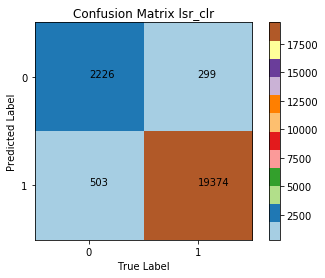

lsr_clr 0.9746943703778236 0.9848015046002135


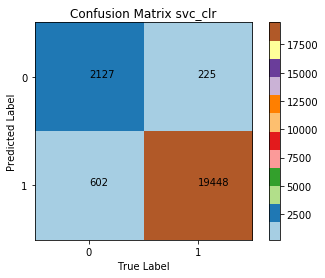

svc_clr 0.9699750623441397 0.9885630051339399


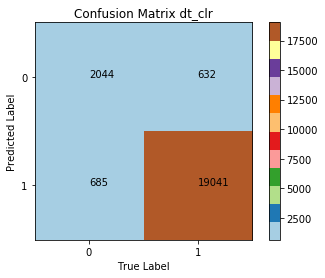

dt_clr 0.9652742573253574 0.9678747521984445


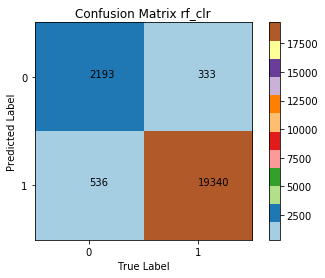

rf_clr 0.973032803380962 0.9830732475982311


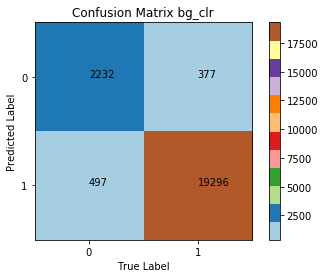

bg_clr 0.974890112666094 0.9808366797133127


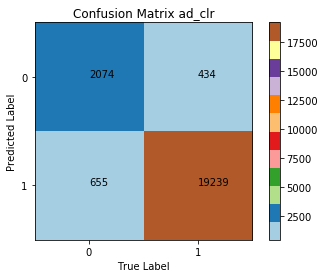

ad_clr 0.9670755001507992 0.9779393076805775


In [261]:
clrs = ['lsr_clr','svc_clr','dt_clr','rf_clr','bg_clr','ad_clr']
for i,y_hat in enumerate(y_hats):
    C = confusion_matrix(y_test,y_hat)
    plot_confusion_matrix(C,clrs[i])
    TN = C[0][0]
    FP = C[0][1]
    FN = C[1][0]
    TP = C[1][1]
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    print(clrs[i],precision,recall)

In [262]:
C = confusion_matrix(y_test,y_hats[1],labels=[0,1])
TN = C[0][0]
FP = C[0][1]
FN = C[1][0]
TP = C[1][1]
precision = TP/(TP+FP)
recall = TP/(TP+FN)

In [263]:
precision,recall

(0.9699750623441397, 0.9885630051339399)

F<sub>$\beta$</sub> = $\frac{(1+\beta ^2 ) \cdot recall\cdot precision }{\beta ^ 2 \cdot precision + recall }$

[0.9797218710493047, 0.9791808272285578, 0.9665727556536968, 0.9780272573263546, 0.9778543556478994, 0.9724770642201834]


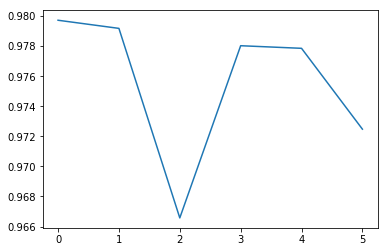

In [268]:
F1 = []
for i,y_hat in enumerate(y_hats):
    F1 .append(f1_score(y_test,y_hat))
plt.plot(range(len(F1)),F1)
print(F1)

综上所述  逻辑回归效果最好

In [269]:
!pwd

/home/mk/User/xiaoma/newsClassify
